# Chapter 4. GMVP Optimization using Hierarchical Clustering 


- __Hyper-parameters to choose from :__

    1. __Scaling methods__ : Standard scaling, Minmax Scaling, or none 
    2. __Dimensionality reduction__ : Principal Component Analysis (PCA), t-distributed stochastic neighbor embedding(t-sne), or none
    3. __How many components to use__ : If we decide to use dimensionality reduction, we also need to decide how many __principal components__ or __t-sne components__ to use.
    4. __Linkage method__ : Several linkage methods exist for hierarchical clustering. e.g. : complete, ward, single...

  
- __Source of codes related with 'Bounded K-means clustering' : <a href = "https://towardsdatascience.com/bounded-clustering-7ac02128c893"> Darya Gartzman's blog </a>__

__Contents__

- [__Step 01. Loading stock data__](#Step-01.-Loading-stock-data)
- [__Step 02. Making custom functions__](#Step-02.-Making-custom-functions)
- [__Step 03. Portfolio optimization__](#Step-03.-Portfolio-optimization)

---

## Step 01. Loading stock data

__1. Importing required libraries__

In [1]:
# for importing libraries again that is already imported, just in case that any change is made in libraries
%load_ext autoreload
%autoreload 2

# libraries for general work
import pickle
import numpy as np
import numpy.random as random
import pandas as pd
from tqdm import tqdm_notebook as tqdm

# for computing portfolio performance
from portfolio_performance_function import *

# Disable printing all warnings on python 
import warnings
warnings.filterwarnings("ignore")

# libraries for Bounded K-means clustering
import geojsonio
import json
import random
import time

from geojson import Point as GeojsonPoint, Feature, FeatureCollection
from shapely.geometry import Point as ShapelyPoint, Polygon
from sklearn.datasets import make_blobs

random_seed = 314
random.seed(random_seed)
np.random.seed(random_seed)

# libraries related with normalization
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

# libraries related with plotting
import seaborn as sns
import matplotlib.pyplot as plt

# libraries for using PCA
from sklearn.decomposition import PCA

# libraries for using t-sne on GPU : https://github.com/rapidsai/cuml
import cudf
from cuml.manifold import TSNE 

__2. Loading daily price of all stocks for indexing dates : `daily_price_df`__

In [4]:
# Loading
with open('./data/russel1000_daily_price_df.pickle', 'rb') as f:
    daily_price_df = pickle.load(f)
del daily_price_df.index.name

daily_price_df.head(3)

,MMM,ABT,ABMD,ACHC,ATVI,ADBE,AMD,AES,AMG,AFL,...,ZBRA,ZION,XEL,XRX,XLNX,YUM,BRK-B,HEI-A,LGF-A,JW-A
1999-11-01,26.186508,7.625059,10.2500,3.750,1.057096,17.013006,10.15625,22.383265,17.685398,5.895580,...,26.222221,44.172218,8.828288,59.627827,28.284966,4.807233,41.740002,1.899360,1.423901,12.179971
1999-11-02,26.430267,7.187653,10.3125,3.750,1.071191,16.888933,10.28125,22.780302,17.523146,6.068317,...,25.388889,45.481014,8.853581,57.188522,28.801279,4.733161,42.820000,1.891793,1.385417,12.134530
1999-11-03,26.325787,6.963037,10.2500,3.875,1.089984,17.075039,10.65625,22.209560,17.604273,6.150932,...,24.944445,44.920109,8.727110,57.324043,30.417568,4.651680,43.060001,1.755583,1.539352,11.725501


__3. Creating a list of all tickers : `all_tickers_list`__

In [5]:
all_ticker_list = list(daily_price_df.columns)

__4. Loading a grouped daily return data for validation : `daily_return_df_list_validation`__

In [6]:
# Loading
with open('./data/russel1000_daily_return_df_validation.pickle', 'rb') as f:
    daily_return_df_list_validation = pickle.load(f)
    
print(f"Total number of portfolio rebalancing  : {len(daily_return_df_list_validation)}" )
print(f"shape of dataframe : {daily_return_df_list_validation[0].shape}" )

Total number of portfolio rebalancing  : 47
shape of dataframe : (252, 590)


In [7]:
print("---validation---")
print(f"first day date: {daily_return_df_list_validation[1].index[-60].date()}")
print(f"last day date: {daily_return_df_list_validation[-1].index[-1].date()}")

---validation---
first day date: 2000-10-31
last day date: 2011-10-20


In [8]:
# investment dates
investment_date_validation = daily_price_df.loc['2000-10-31':'2011-10-20',:].index
len(investment_date_validation)

2760

__5. Loading a grouped daily return data for test : `daily_return_df_list_test`__

In [9]:
# Loading
with open('./data/russel1000_daily_return_df_test.pickle', 'rb') as f:
    daily_return_df_list_test = pickle.load(f)
    
print(f"Total number of portfolio rebalancing : {len(daily_return_df_list_test)}" )
print(f"shape of dataframe : {daily_return_df_list_test[0].shape}" )

Total number of portfolio rebalancing : 31
shape of dataframe : (252, 590)


In [10]:
print("---test---")
print(f"first day date: {daily_return_df_list_test[1].index[-60].date()}")
print(f"last day date: {daily_return_df_list_test[-1].index[-1].date()}")

---test---
first day date: 2012-10-04
last day date: 2019-11-29


In [11]:
# investment dates
investment_date_test = daily_price_df.loc['2012-10-04':'2019-11-29',:].index
len(investment_date_test)

1800

---

## Step 2. Creating classes and methods for `Bounded K-means clustering`

In [12]:
class ClustersUtils:
    
    @classmethod
    def compute_dist_array(cls, X: np.array) -> np.array:
        dist_array = np.array([[np.linalg.norm(x1 - x2)
                                for x1 in X]
                               for x2 in X])
        return dist_array
    
    @classmethod
    def scatter_plot(cls, X: np.array, clusters_in_idxs: [[int]], centroid_idxs: [int] = None):
        """Only plots first two dimensions"""
        x, y = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                          for one_cluster_in_idxs in clusters_in_idxs
                          for c_idx in one_cluster_in_idxs]))
        c = [color_idx
             for color_idx, one_cluster_in_idxs in enumerate(clusters_in_idxs)
             for _ in one_cluster_in_idxs]
        df = pd.DataFrame({'x': x, 'y': y, 'c': c})

        fig, ax = plt.subplots()
        for color_idx, cluster_in_idxs in enumerate(clusters_in_idxs):
            df_temp = df[df['c'].isin([color_idx])]
            plt.plot(df_temp['x'].tolist(), df_temp['y'].tolist(), 'o', label=color_idx, markersize=5)

        if centroid_idxs is not None:
            x_c, y_c = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                                  for c_idx in centroid_idxs]))
            plt.plot(x_c, y_c, 'o', color='black', markersize=3)

        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()
        
    @classmethod
    def plot_families_on_map(cls, points_coords_lng_lat: [[float]], family_size: np.array) -> None:
        features = []
        color = "#251782"
        for lng_lat, s in zip(points_coords_lng_lat, family_size):
            p = Feature(geometry=GeojsonPoint(lng_lat), 
                        properties={"marker-symbol": int(s), "marker-color": color})
            features += [p]

        feature_collection = FeatureCollection(features=features)
        geojsonio.display(json.dumps(feature_collection));
        
    @classmethod
    def plot_clustering_on_map(cls, clusters_in_idxs: [[int]], 
                               points_coords_lng_lat: [[float]], family_size: np.array) -> None:
        features = []
        for cluster_idxs in clusters_in_idxs:
            color = "#" + ''.join(random.choices('0123456789abcdef', k=6))
            for idx in cluster_idxs:
                properties = {"marker-symbol": int(family_size[idx]), "marker-color": color}
                p = Feature(geometry=GeojsonPoint(points_coords_lng_lat[idx]), properties=properties)
                features += [p]

        feature_collection = FeatureCollection(features=features)
        geojsonio.display(json.dumps(feature_collection));

In [15]:
class BoundedKMeansClustering:
    def __init__(self, n_clusters: int, max_cluster_size: int, n_iter: int = 10, n_init: int = 10, plot_every_iteration=False):
        self.n_clusters = n_clusters
        self.max_cluster_size = max_cluster_size
        self.n_iter = n_iter
        self.n_init = n_init
        self.plot_every_iteration = plot_every_iteration

        self.n_points = None

    def fit(self, X: np.array, weights: np.array, dist_array: np.array = None) -> [float, [[int]]]:
        self.n_points = X.shape[0]
        dist_array = dist_array if dist_array is not None else ClustersUtils.compute_dist_array(X)

        costs, clusters = zip(*[self.fit_one_iteration(X, weights, dist_array) for _ in range(self.n_init)])

        if all(np.isnan(np.array(costs))):
            return np.nan, np.nan
        
        best_idx = np.nanargmin(costs)
        best_cost = costs[best_idx]
        best_clusters = clusters[best_idx]

        self.n_points = None
        return best_cost, best_clusters

    def fit_one_iteration(self, X: np.array, weights: np.array, dist_array: np.array) -> [float, [[int]]]:
        # inspired by https://core.ac.uk/download/pdf/61217069.pdf

        try:
            clusters_in_idxs = self._initialize_clusters(weights, dist_array)
            best_clusters = clusters_in_idxs
            best_cost = self._get_maximal_mean_dist_in_clusters(dist_array, clusters_in_idxs)

            for i in range(self.n_iter):
                clusters_in_idxs, maximal_mean_dist_in_clusters = self._optimize_clusters(X, weights, dist_array,
                                                                                          clusters_in_idxs)
                if clusters_in_idxs == best_clusters:
                    # print(f"Reached a local optimum after {i} iterations.")
                    break
                
                if maximal_mean_dist_in_clusters < best_cost:
                    best_cost = maximal_mean_dist_in_clusters
                    best_clusters = clusters_in_idxs
                    
            if self.plot_every_iteration:
                ClustersUtils.scatter_plot(X, best_clusters)

        except ValueError:
            best_cost, best_clusters = np.nan, np.nan

        return best_cost, best_clusters

    def _initialize_clusters(self, weights: np.array, dist_array: np.array) -> [[int]]:
        centroid_idxs = random.sample(range(self.n_points), self.n_clusters)
        clusters_in_idxs = self._assign_points_to_clusters(weights, dist_array, centroid_idxs)
        return clusters_in_idxs

    def _assign_points_to_clusters(self, weights: np.array, dist_array: np.array, centroid_idxs: [int]) -> [[int]]:
        clusters_in_idxs = [[c_idx] for c_idx in centroid_idxs]
        cluster_weights = np.array([weights[c_idx] for c_idx in centroid_idxs])

        sorted_points_idxs_by_weights = [i for i in np.argsort(-weights,  axis=0) if i not in centroid_idxs]
        for p_idx in sorted_points_idxs_by_weights:
            is_assigned = False
            sorted_cluster_idxs_by_dist = np.argsort(dist_array[p_idx][centroid_idxs])
            for c_idx in sorted_cluster_idxs_by_dist:
                if cluster_weights[c_idx] + weights[p_idx] <= self.max_cluster_size:
                    clusters_in_idxs[c_idx].append(p_idx)
                    cluster_weights[c_idx] += weights[p_idx]
                    is_assigned = True
                    break
            if not is_assigned:
                raise ValueError(
                    f"Point {p_idx} could not be assigned. Try with more than {self.n_clusters} clusters. "
                    f"Current_clusters in idxs: {clusters_in_idxs}")

        return clusters_in_idxs

    def _get_maximal_mean_dist_in_clusters(self, dist_array: np.array, clusters_in_idxs: [[int]]):
        mean_dist_in_all_clusters = [self._get_mean_dist_in_cluster(dist_array, one_cluster_in_idxs)
                                     for one_cluster_in_idxs in clusters_in_idxs]
        maximal_mean_dist_in_clusters = max(mean_dist_in_all_clusters)
        return maximal_mean_dist_in_clusters

    def _get_mean_dist_in_cluster(self, dist_array: np.array, cluster_in_idxs: [[int]]) -> float:
        cluster_sub_dist_array = dist_array[cluster_in_idxs, :][:, cluster_in_idxs]
        cluster_sub_dist_array_triu = np.triu(cluster_sub_dist_array)
        cluster_sub_dist_array_triu[cluster_sub_dist_array_triu == 0] = np.nan
        mean_dist_in_cluster = np.nanmean(cluster_sub_dist_array)
        return mean_dist_in_cluster

    def _optimize_clusters(self, X: np.array, weights: np.array, dist_array: np.array, clusters_in_idxs: [[int]]):
        centroid_idxs = self._update_centroids(X, clusters_in_idxs)
        clusters_in_idxs = self._assign_points_to_clusters(weights, dist_array, centroid_idxs)
        maximal_mean_dist_in_clusters = self._get_maximal_mean_dist_in_clusters(dist_array, clusters_in_idxs)        
        return clusters_in_idxs, maximal_mean_dist_in_clusters

    def _update_centroids(self, X: np.array, clusters_in_idxs: [[int]]) -> [int]:
        updated_centroid_idxs = [self._update_centroid_for_one_cluster(X, one_cluster_in_idxs)
                                 for one_cluster_in_idxs in clusters_in_idxs]
        return updated_centroid_idxs

    def _update_centroid_for_one_cluster(self, X: np.array, cluster_in_idxs: [int]) -> int:
        center = np.mean(X[cluster_in_idxs], axis=0)
        closest_point_idx_in_cluster = np.argmin(np.linalg.norm(X[cluster_in_idxs] - center, axis=1))
        closest_point_idx = cluster_in_idxs[closest_point_idx_in_cluster]
        return closest_point_idx

---

## Step 03. Creating functions for portfolio optimization

- As the clustering approach to GMVP performs portfolio optimization twice, we are going to build two functions
    1. __within cluster optimization : `GMVP_within_cluster`__
    2. __between clusters optimization: `GMVP_between_clusters`__

__1. `GMVP_within_cluster` : This function is used inside another function, `GMVP_between_clusters`.__
- __Input :__  
    1. daily_return_df_list
- __Output :__
    1. daily_cluster_returns  
    2. within_cluster_weights

In [16]:
def GMVP_within_cluster(data_period, index, stock_list_of_cluster):
    
    if data_period == 'validation':
        daily_return_df_list = daily_return_df_list_validation
    elif data_period == 'test':
        daily_return_df_list = daily_return_df_list_test
    
    # slice the data needed
    daily_stock_return_of_cluster_df = daily_return_df_list[index].loc[:, stock_list_of_cluster]
    
    # get the covariance matrix and inverse matrix of covariance matrix respectively
    cov_mat_of_stock_within_cluster_df = daily_stock_return_of_cluster_df.cov()
    cov_mat_of_stock_within_cluster_array = cov_mat_of_stock_within_cluster_df.values
    inv_cov_mat_array = np.linalg.pinv(cov_mat_of_stock_within_cluster_array) # Use pseudo-inverse incase matrix is singular / ill-conditioned

    # construct minimum variance weights
    one_vector_array = np.ones(len(inv_cov_mat_array))
    inv_dot_one_array = np.dot(inv_cov_mat_array, one_vector_array)
    within_cluster_weight_array = inv_dot_one_array/ np.dot(inv_dot_one_array, one_vector_array)
    
    # calculate the daily_return
    daily_weighted_stock_return_df = (daily_stock_return_of_cluster_df * within_cluster_weight_array)
    daily_cluster_return_df = daily_weighted_stock_return_df.sum(axis=1)
    
    return daily_cluster_return_df, within_cluster_weight_array

__2. `GMVP_between_clusters`__
- __Input :__  
    1. daily_return_df_list
- __Output :__  
    1. daily_portfolio_returns   
    2. in_sample_stdev  
    3. out_of_sample_stdev  
    4. individual_stock_weights  
    5. sector_weights  
    6. sector_returns_df_list

In [17]:
def GMVP_between_clusters(data_period, max_cluster_size, scaling_method='none', dim_reduction_method='none', no_of_PCA_components = 0, no_of_tsne_components = 0):
    rebalancing_period = 60
    
    ################## creating lists and dictionaries for storing outcomes ##################
    # 1) returns
    daily_portfolio_return_list = []   # daily returns of portfolio
    # 2) stdev
    in_sample_stdev_list = []          # standard deviation of in-sample (252-day-long) daily portfolio returns
    out_of_sample_stdev_list = []      # standard deviation of out-of-sample (60-day-long) daily portfolio returns
    # 3) cluster & stock 
    cluster_and_stock_dict = {}        # 1. cluster_return : 252_daily_returns * 11_clusters
                                       # 2. cluster_weight : weights of each 11 cluster
                                       # 3. cluster_ticker : tickers belonging to each cluster 
                                       # 4. stock_weight   : weights of each individual stock
                                       # 5. daily_return_for_viz 
    ##########################################################################################
    
    if data_period == 'validation':
        daily_return_df_list = daily_return_df_list_validation
    elif data_period == 'test':
        daily_return_df_list = daily_return_df_list_test
    
    for index_no, daily_return_df in enumerate(tqdm(daily_return_df_list)):
        
        cluster_weight_dict = {}   # weights of each 11 cluster
        cluster_ticker_dict = {}   # tickers belonging to each cluster 
        stock_weight_within_cluster_dict = {} # weights of each individual stock
        
        ################## 1. normalizing data ##################
        if scaling_method == 'standard_scale':    
            scaled_daily_price_array = (standard_scaler.fit_transform(daily_return_df))
            after_scaling_return_df = pd.DataFrame(scaled_daily_price_array, columns = all_ticker_list).T
        elif scaling_method == 'none':
            after_scaling_return_df = daily_return_df.T
        
        ################## 2. dimensionality reduction ##################
        if dim_reduction_method == 'PCA':
            pca = PCA(n_components=no_of_PCA_components)
            scaled_daily_return_PCA_array = pca.fit_transform(current_daily_return_df)
            after_dim_reduction_return_df = pd.DataFrame(scaled_daily_return_PCA_array, index = all_ticker_list)  # shape : [stocks * PCs]
        elif dim_reduction_method == 'tsne':
            tsne = TSNE(n_components = no_of_tsne_components)
            scaled_daily_return_tsne_cudf = tsne.fit_transform(current_daily_return_df.values)
            after_dim_reduction_return_df = pd.DataFrame(scaled_daily_return_tsne_cudf, index = all_ticker_list)
        elif dim_reduction_method == 'none':
            after_dim_reduction_return_df = after_scaling_return_df
            
        ################## 3. bounded k-means clustering  ################## 
        n_clusters = 11
        n_iter = 10
        n_init = 10

        weights = np.ones(after_dim_reduction_return_df.shape[0]) # The original code is created to consider the observations' weights, which is not needed in our research.
                                                                  # As we judge stocks solely based on return movements while coming up with a portfolio, we assign 1 to every stock.

        cluster_maker = BoundedKMeansClustering(n_clusters, max_cluster_size, n_iter, n_init)
        best_cost, best_clusters = cluster_maker.fit(after_dim_reduction_return_df.values, weights)
        after_dim_reduction_return_df.loc[:,'cluster_label'] = 0  # assign false classification 0 at first, but correctly classifies stocks right after. 
        
        for cluster_label in range(n_clusters):
            ticker_index_list =  best_clusters[cluster_label]
            cluster_ticker_list = list(np.array(all_ticker_list)[ticker_index_list])
            after_dim_reduction_return_df.loc[cluster_ticker_list,'cluster_label'] = cluster_label
            
        # storing clustering results in a dict : cluster_ticker_dict
        cluster_label_list = list((after_dim_reduction_return_df.loc[:,'cluster_label'].unique()))
        for cluster_label in cluster_label_list:
            cluster_ticker_dict[cluster_label] = list(after_dim_reduction_return_df[after_dim_reduction_return_df.loc[:,'cluster_label'] == cluster_label].index)
        
        ################## (Optional) For visualization ##################
        pca = PCA(n_components=2)
        daily_return_array_for_viz = pca.fit_transform(after_dim_reduction_return_df.iloc[:,:-1])
        daily_return_df_for_viz = pd.DataFrame(daily_return_array_for_viz, index = all_ticker_list)  # shape : [stocks * PCs]
        daily_return_df_for_viz.loc[: ,'cluster_label'] = after_dim_reduction_return_df.loc[:,'cluster_label']
        daily_return_df_for_viz.rename(columns = {0: 'PC_1',1:'PC_2'}, inplace=True)
        
        # --------------------- #
        #  GMVP within cluster  #
        # --------------------- #
        # GMVP on each cluster using the function 'GMVP_within_cluster' --> to create a matrix of daily returns of clusters
        stock_weight_within_cluster_dict = {}
        daily_cluster_return_dict = {}
        
        ################## 4. computing stock weights within a cluster ##################
        for cluster_label in cluster_label_list:
            daily_cluster_return_series, stock_weight_within_cluster_array = GMVP_within_cluster(data_period, index_no, cluster_ticker_dict[cluster_label])
            daily_cluster_return_dict[cluster_label] = daily_cluster_return_series
            stock_weight_within_cluster_dict[cluster_label] = stock_weight_within_cluster_array

        daily_cluster_return_df = pd.DataFrame.from_dict(daily_cluster_return_dict)
        
        # ---------------------- #
        #  GMVP between clusters #
        # ---------------------- #
        cov_mat_of_cluster_df = daily_cluster_return_df.cov()
        cov_mat_of_cluster_array = cov_mat_of_cluster_df.values
        inv_cov_mat_array = np.linalg.pinv(cov_mat_of_cluster_array) # Use pseudo-inverse incase matrix is singular / ill-conditioned

        ################## 5. computing cluster weights ##################
        one_vector_array = np.ones(len(inv_cov_mat_array))
        inv_dot_one_array = np.dot(inv_cov_mat_array, one_vector_array)
        cluster_weight_array = inv_dot_one_array/ np.dot( inv_dot_one_array , one_vector_array)
        cluster_weight_df = pd.DataFrame(data= cluster_weight_array, columns = ['weight'], index = cluster_label_list)
        
        # compute stdev of portfolio, which can be calculated from daily returns of clusters
        in_sample_variance = np.dot(cluster_weight_array, np.dot(cov_mat_of_cluster_array, cluster_weight_array))
        in_sample_stdev = np.sqrt(in_sample_variance)
        in_sample_stdev_list.append(in_sample_stdev)
        
        ################## 6. computing stock weights in a portfolio (portfolio weights) ##################
        temp_portfolio_weight_list = []

        for cluster_label in cluster_label_list:
            stock_weight_within_sector_array =  cluster_weight_df.loc[cluster_label,'weight'] * stock_weight_within_cluster_dict[cluster_label]
            stock_weight_within_sector_df = pd.DataFrame(stock_weight_within_sector_array, index = cluster_ticker_dict[cluster_label], columns = ['weight'])
            temp_portfolio_weight_list.append(stock_weight_within_sector_df)

        portfolio_weight_df = pd.concat(temp_portfolio_weight_list)
        
        # ---------------------------------------------------------- #
        # Calculating daily return based on GMV optimization results #
        # ---------------------------------------------------------- #
        # we should use 'index+1' ; we optimize portfolio at the time point 'index' and see how it goes for the time period from 'index' to 'index+1'
        if (index_no+1) < len(daily_return_df_list):
            
            # appending to the list only if we invest in the market, following the portfolio optimization
            in_sample_stdev_list.append(in_sample_stdev)
            
            # appending data only if the data is used for calculating next time's return 
            future_daily_return_df = daily_return_df_list[index_no+1]
            future_daily_cluster_return_dict = {}

            for cluster_label in cluster_label_list:

                # 1st optimization - cluster_weight calculated from 'between_cluster GMV'
                cluster_weight = cluster_weight_df.loc[cluster_label,'weight']
                # 2nd optimization - stock_weight calculated from 'inside_cluster GMV'
                stock_weight_within_cluster_array = stock_weight_within_cluster_dict[cluster_label]
                # based on the asset allocation reuslt from 1st optimization and 2nd optimization, now we can compute the each stock's weight
                future_daily_cluster_return_df = (future_daily_return_df.loc[:, cluster_ticker_dict[cluster_label]] * stock_weight_within_cluster_array * cluster_weight)
                future_daily_cluster_return_series = future_daily_cluster_return_df.sum(axis=1)[-rebalancing_period:]
                future_daily_cluster_return_dict[cluster_label] = future_daily_cluster_return_series

            # out-of-sample daily portfolio returns (60 days)
            future_daily_cluster_return_df = pd.DataFrame.from_dict(future_daily_cluster_return_dict)
            daily_portfolio_return_series_60days = future_daily_cluster_return_df.sum(axis=1)
            daily_portfolio_return_list.extend(daily_portfolio_return_series_60days)
            
            # standard deviation of out-of-sample portfolio returns
            out_of_sample_stdev = daily_portfolio_return_series_60days.std()
            out_of_sample_stdev_list.append(out_of_sample_stdev)
            
            # saving outcomes to a dictionary
            cluster_and_stock_dict[index_no] = {'cluster_return' : daily_cluster_return_df,
                                                'cluster_weight' : cluster_weight_df,
                                                'cluster_ticker' : cluster_ticker_dict,
                                                'stock_weight' : portfolio_weight_df,
                                                'daily_return_for_viz' : daily_return_df_for_viz
                                                }
            
    daily_portfolio_return_array = np.array(daily_portfolio_return_list)
    in_sample_stdev_series = pd.Series(in_sample_stdev_list)
    out_of_sample_stdev_series = pd.Series(out_of_sample_stdev_list)
    
    return daily_portfolio_return_array, in_sample_stdev_series, out_of_sample_stdev_series, cluster_and_stock_dict

---

## Step 03. Portfolio optimization
- With custom functions that we have created above, now we can perform GMV portfolio optimization on 591 stocks from either periods, validation period or test period.
- An example is provided for you to learn how we can use custom functions for performing portfolio optimization


sharpe_ratio : 0.09892
sortino_ratio : 0.13909
out-of-sample std : 0.00511
CVaR_95 : -0.92
MDD : -8.61
downside_stdev : 0.00379
real_stdev : 0.00533300601269795


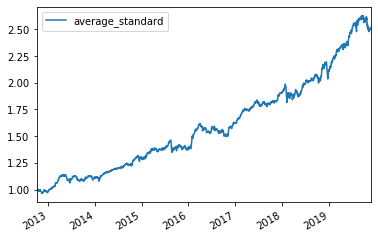


sharpe_ratio : 0.10473
sortino_ratio : 0.14602
out-of-sample std : 0.00504
CVaR_95 : -0.92
MDD : -10.66
downside_stdev : 0.00377
real_stdev : 0.0052485185691241235


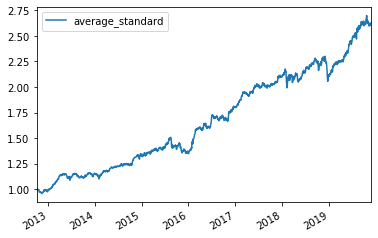


sharpe_ratio : 0.09992
sortino_ratio : 0.13961
out-of-sample std : 0.00509
CVaR_95 : -0.93
MDD : -8.96
downside_stdev : 0.00379
real_stdev : 0.005290052442452656


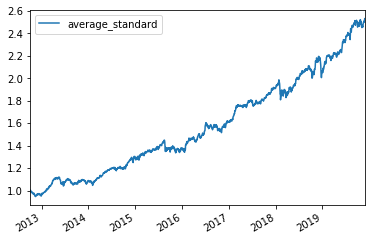


sharpe_ratio : 0.08350
sortino_ratio : 0.11736
out-of-sample std : 0.00525
CVaR_95 : -0.97
MDD : -10.70
downside_stdev : 0.00389
real_stdev : 0.005466275896806897


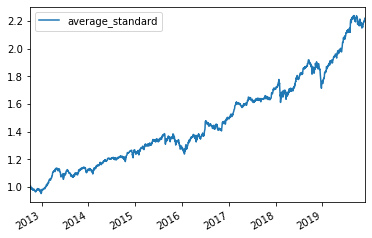


sharpe_ratio : 0.11376
sortino_ratio : 0.16193
out-of-sample std : 0.00513
CVaR_95 : -0.92
MDD : -8.84
downside_stdev : 0.00377
real_stdev : 0.005358760822387058


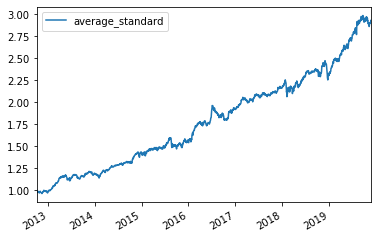

In [21]:
for i in range(5):
    (portfolio_return, in_sample_std, out_of_sample_std, cluster_and_stock_dict) = GMVP_between_clusters(data_period = 'test', 
                                                                                                         max_cluster_size = 75)
    print(f"sharpe_ratio : {get_single_sharpe_ratio(portfolio_return):.5f}")
    print(f"sortino_ratio : {get_single_sortino_ratio(portfolio_return):.5f}")
    print(f"out-of-sample std : {out_of_sample_std.mean():.5f}")
    print(f"CVaR_95 : {get_cvar_95(portfolio_return)*100:.2f}")
    print(f"MDD : {get_maximum_drawdown(portfolio_return)*100:.2f}")
    print(f"downside_stdev : {get_single_downside_stdev(portfolio_return):.5f}")
    print(f"real_stdev : {portfolio_return.std()}")
    portfolio_return_df = pd.DataFrame(portfolio_return, index = investment_date_test, columns = ['average_standard'])
    cumulative_wealth_df = (portfolio_return_df+1).cumprod()
    (cumulative_wealth_df.plot())
    plt.show()

__1. Cumulative_wealth__

In [ ]:
out_of_sample_std.mean()

In [ ]:
portfolio_return_df = pd.DataFrame(portfolio_return, index = investment_date_test, columns = ['average_standard'])
cumulative_wealth_df = (portfolio_return_df+1).cumprod()
cumulative_wealth_df.plot()

In [ ]:
out_of_sample_std.mean()

In [ ]:
portfolio_return_df = pd.DataFrame(portfolio_return, index = investment_date_test, columns = ['average_standard'])
cumulative_wealth_df = (portfolio_return_df+1).cumprod()
cumulative_wealth_df.plot()

In [ ]:
portfolio_return_df = pd.DataFrame(portfolio_return, index = investment_date_test, columns = ['average_standard'])
cumulative_wealth_df = (portfolio_return_df+1).cumprod()
cumulative_wealth_df.plot()

__2. Visualization of daily returns of stocks using two principal components__

In [ ]:
# first period of validation period
cluster_and_stock_dict[0]['daily_return_for_viz'].head(3)

In [ ]:
daily_return_for_viz = cluster_and_stock_dict[0]['daily_return_for_viz']
daily_return_for_viz['cluster_label'] = 'cluster_' + daily_return_for_viz['cluster_label'].astype(str)
daily_return_for_viz.head(3)

In [ ]:
daily_return_for_viz.loc[:,'cluster_label'].value_counts()

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='PC_1', y='PC_2', hue="cluster_label", data=daily_return_for_viz)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2)

---